# Spotify Insights
note: The value of streams is NULL when the chart column is "viral50".

1. Carga de um conjunto de dados com um volume de dados adequado para o contexto da
disciplina (+1000 registros);
2. Realização do pré-processamento sobre o conjunto de dados;
3. A partir do conjunto resultante (pré-processado), estatísticas e visualizações devem ser
geradas para promover um entendimento inicial dos dados;
4. Com o conjunto de dados do item 3 aplique algum algoritmo de aprendizado de máquina,
apresente e discuta os resultados obtidos. Talvez seja necessário realizar transformações
para que os dados se adequem ao algoritmo escolhido.
A partir disso, cada equipe deve realizar uma apresentação discutindo todos os itens da
implementação (descrição e carga do conjunto de dados, pré-processamento realizado,
estatísticas e visualizações e, por fim, utilização de um algoritmo de aprendizado de máquina
com apresentação dos resultados).

In [4]:
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
import time


In [5]:

# data = pd.read_csv('charts.csv')
# kernel chashed

start = time.time()
#read data in chunks of 1 million rows at a time
chunk = pd.read_csv('charts.csv',chunksize=100000)
end = time.time()
data = pd.concat(chunk)
data.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [4]:
data['artist'].value_counts()

Ed Sheeran                                                                 387917
Billie Eilish                                                              251825
Post Malone                                                                211272
Bad Bunny                                                                  203403
Ariana Grande                                                              189914
                                                                            ...  
Ezhel, Patron, Anıl Piyancı, Sansar Salvo, Allame, Pit10, Beta, Kamufle         1
Lips, George Mason, Rose McIver, Kimbra                                         1
Joakim Kleven, KOH                                                              1
Lazyloxy, Maiyarap, OG-ANIC, UrboyTJ                                            1
Luna 99                                                                         1
Name: artist, Length: 96156, dtype: int64

In [6]:

from pyspark.sql import DataFrame

spark = (SparkSession.builder.config("spark.driver.memory","4g").config("spark.driver.maxResultSize", "4g").getOrCreate())
# import dataframe by spark

df = spark.read.csv(path='charts.csv', inferSchema=True, header=True)
df = df.withColumn("rank", f.col("rank").cast(t.IntegerType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/07 02:02:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Word Cloud

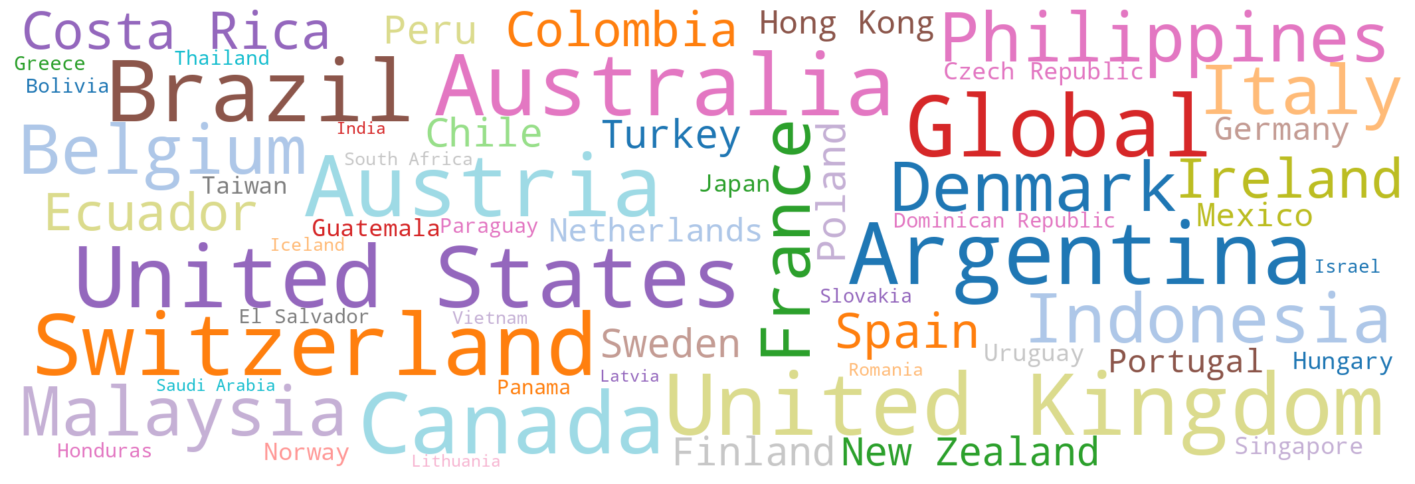

In [17]:

import matplotlib.pyplot as plt

from wordcloud import WordCloud

def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white',
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

counts = data['region'].value_counts()

visualize_word_counts(counts)

### 


In [19]:
# most streamed song in brazil 3D scatter(x, y, z) chart
from numpy import nan

datachart = df.filter(df.region == 'Brazil').groupBy('title', 'date').sum('streams').sort(f.col('sum(streams)').desc()).toPandas()
datachart['title'] = datachart['title'].replace('INTERE$$EIRA', 'interesseira')
datachart['sum(streams)'] = datachart['sum(streams)'].replace(nan, None)
datachart = datachart.dropna()

datachart

,title,date,sum(streams)
0,Vai malandra (feat. Tropkillaz & DJ Yuri Martins),2017-12-19,2001683.0
1,Vai malandra (feat. Tropkillaz & DJ Yuri Martins),2017-12-20,1960966.0
2,Batom de Cereja - Ao Vivo,2021-04-10,1899844.0
3,Meu Pedaço de Pecado,2021-07-24,1794033.0
4,Vai malandra (feat. Tropkillaz & DJ Yuri Martins),2017-12-21,1772313.0
...,...,...,...
363792,Minha Felicidade,2017-01-08,26061.0
363793,Tenebrosa,2017-01-22,26005.0
363794,Mexidinho - Ao Vivo,2017-01-08,25849.0
363795,Logo Eu,2017-01-22,25846.0


/home/matheus/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from current font.
  func(*args, **kwargs)
/home/matheus/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from current font.
  func(*args, **kwargs)
/home/matheus/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from current font.
  func(*args, **kwargs)
/home/matheus/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 37326 (\N{CJK UNIFIED IDEOGRAPH-91CE}) missing from current font.
  func(*args, **kwargs)
/home/matheus/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 29539 (\N{CJK UNIFIED IDEOGRAPH-7363}) missing from current font.
  func(*args, **kwargs)
/home/matheus/.local/lib/python3.10/site-packages/IPython/core/events.py:89: U

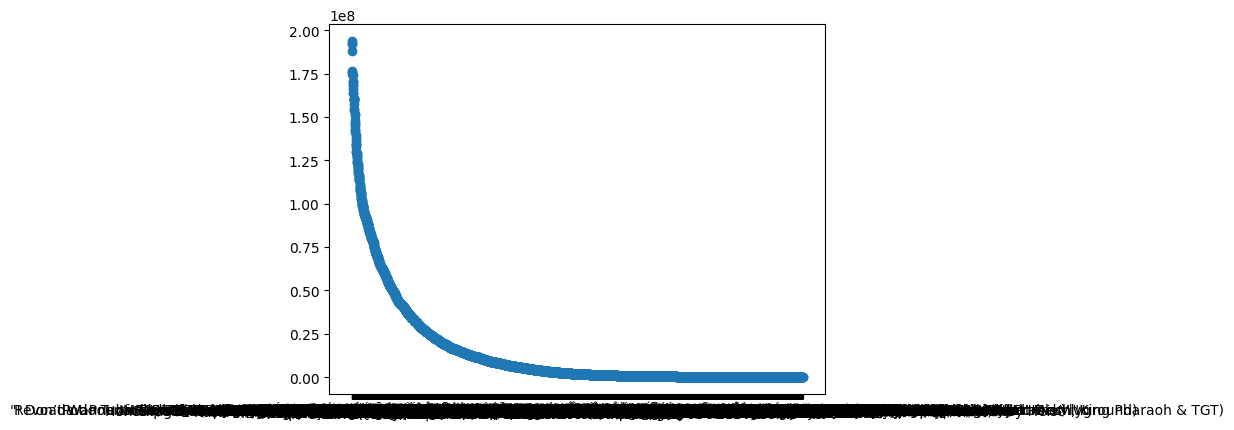

In [18]:
# plt.scatter(x='title', y='sum(streams)', data= datachart)

In [21]:
# from numpy import nan
# from plotly.offline import iplot
# import plotly.graph_objs as go
# import plotly.express as px

# datachart = df.filter(df.region == 'Brazil').groupBy('title', 'date').sum('streams').sort(f.col('sum(streams)').desc()).toPandas()
# datachart['title'] = datachart['title'].replace('INTERE$$EIRA', 'interesseira')
# datachart['sum(streams)'] = datachart['sum(streams)'].replace(nan, None)
# datachart = datachart.dropna()

# fig = px.scatter_3d(datachart, x='title', y='date', z='sum(streams)')
# fig.show()


### Algoritmo de classificação